# Segmentation

In [13]:
import sys, os
sys.path.append('../')
import matplotlib.pyplot as plt 
import numpy as np

import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Constants

In [14]:
SEED = 666
BATCH_SIZE_TRAIN = 4
BATCH_SIZE_VALIDATION = 4

IMAGE_HEIGHT = 128
IMAGE_WIDTH =  128
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

NUM_OF_EPOCHS = 100

NUM_TRAIN = 424
NUM_VALIDATION = 45

EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_VALIDATION = NUM_VALIDATION // BATCH_SIZE_VALIDATION

data_dir_training = '../data/training'
data_dir_train_img = os.path.join(data_dir_training, 'img')
data_dir_train_mask = os.path.join(data_dir_training, 'mask')

data_dir_validation = '../data/validation'
data_dir_validation_img = os.path.join(data_dir_validation, 'img')
data_dir_validation_mask = os.path.join(data_dir_validation, 'mask')

data_dir_test = '../data/test'
data_dir_test_img = os.path.join(data_dir_test, 'img')
data_dir_test_mask = os.path.join(data_dir_test, 'mask')

## Generators

In [15]:
def create_segmentation_generator_train(img_path, mask_path, BATCH_SIZE, IMG_SIZE, SEED):

    data_gen_args_img = dict(rescale=1./255,
#                      featurewise_center=True,
#                      featurewise_std_normalization=True,
                    rotation_range=5,
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
                     zoom_range=0.3,
                     horizontal_flip = True

    )

    data_gen_args_mask = dict(rescale=1./255,
#                      featurewise_center=True,
#                      featurewise_std_normalization=True,
                     rotation_range=5,
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
                     zoom_range=0.3,
                     horizontal_flip = True
    )



    img_data_gen = ImageDataGenerator(**data_gen_args_img)
    mask_data_gen = ImageDataGenerator(**data_gen_args_mask)

    img_generator = img_data_gen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    mask_generator = mask_data_gen.flow_from_directory(mask_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)

    return zip(img_generator, mask_generator)


    #! do not perform data augmentation in the test generator
def create_segmentation_generator_validation(img_path, mask_path, BATCH_SIZE, IMG_SIZE, SEED):

    data_gen_args = dict(rescale=1./255)

    img_data_gen = ImageDataGenerator(**data_gen_args)
    mask_data_gen = ImageDataGenerator(**data_gen_args)

    img_generator = img_data_gen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    mask_generator = mask_data_gen.flow_from_directory(mask_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)

    return zip(img_generator, mask_generator)

def create_segmentation_generator_test(img_path, mask_path, BATCH_SIZE, IMG_SIZE, SEED):

    data_gen_args = dict(rescale=1./255)

    img_data_gen = ImageDataGenerator(**data_gen_args)
    mask_data_gen = ImageDataGenerator(**data_gen_args)

    img_generator = img_data_gen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    mask_generator = mask_data_gen.flow_from_directory(mask_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)

    return zip(img_generator, mask_generator)

In [16]:
train_generator = create_segmentation_generator_train(data_dir_train_img, data_dir_train_mask, BATCH_SIZE_TRAIN, IMG_SIZE, SEED)

validation_generator = create_segmentation_generator_validation(data_dir_validation_img, data_dir_validation_mask, BATCH_SIZE_VALIDATION, IMG_SIZE, SEED)

Found 424 images belonging to 1 classes.
Found 424 images belonging to 1 classes.
Found 45 images belonging to 1 classes.
Found 45 images belonging to 1 classes.


In [17]:
def display(display_list):
    plt.figure(figsize=(12,8))
    title = ['Input image', 'True Mask', 'Predicted mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [18]:
def show_dataset(datagen, num=1):
    for i in range(0, num):
        image, mask = next(datagen)
        display([image[0], mask[0]])


### Show trainig data

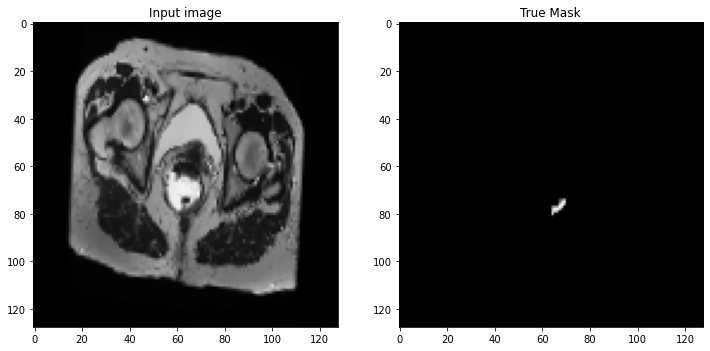

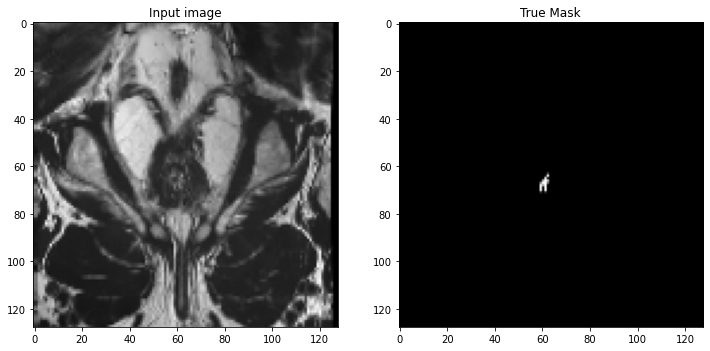

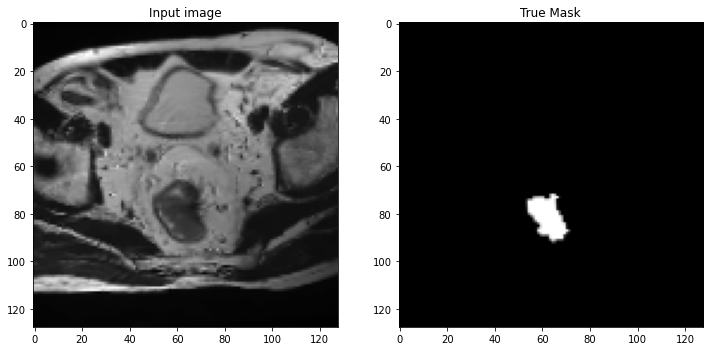

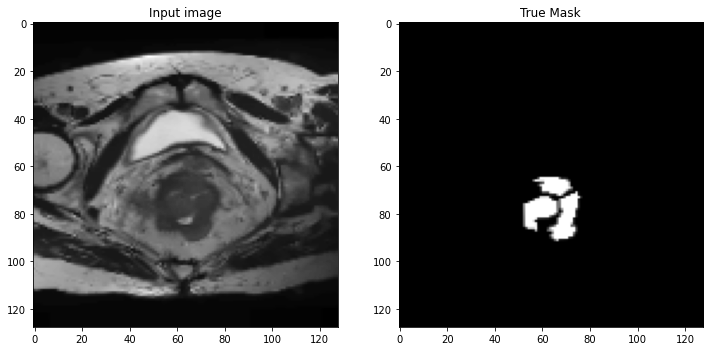

In [19]:
show_dataset(train_generator, 4) # training

### Show test data

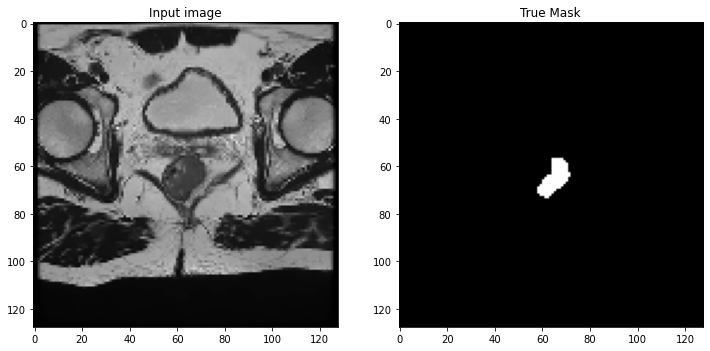

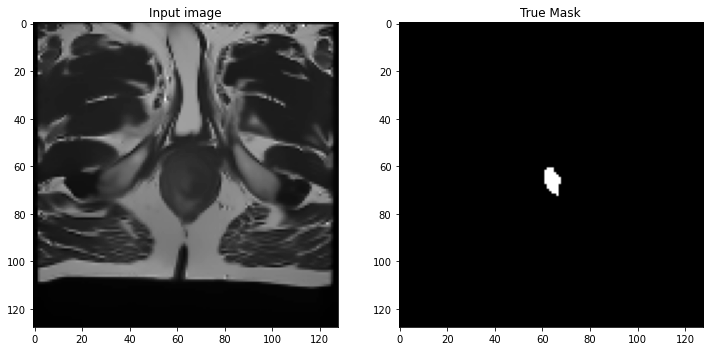

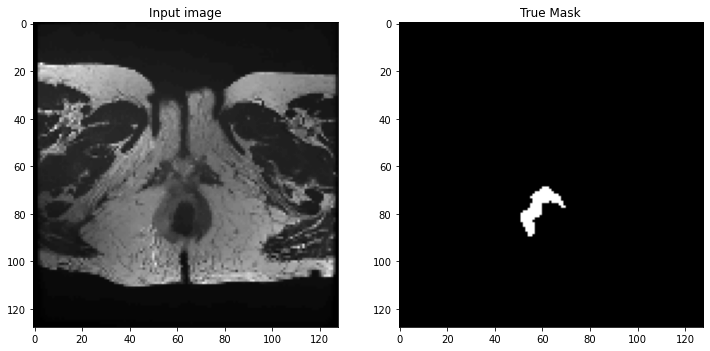

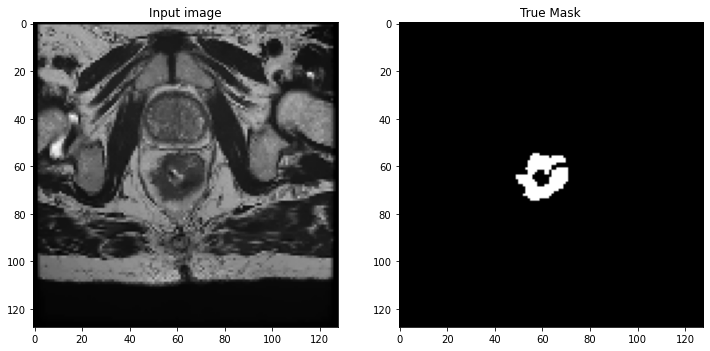

In [20]:
show_dataset(validation_generator, 4) # validation

## U-Net Model

In [21]:
def unet(n_levels=4, initial_features=64, n_conv=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_conv):
            x = tf.keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = tf.keras.layers.MaxPool2D(pooling_size)(x)
            
    # upstream
    for level in reversed(range(n_levels-1)):
        x = tf.keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = tf.keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_conv):
            x = tf.keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = tf.keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return tf.keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [22]:
from tensorflow.keras import backend as K

def dice_coe(output, target, loss_type='jaccard', axis=(1, 2, 3), smooth=1e-5):
    """
    Soft dice (Sørensen or Jaccard) coefficient for comparing the similarity of two batch of data, 
    usually be used for binary image segmentation
    i.e. labels are binary. 
    The coefficient between 0 to 1, 1 means totally match.

    Parameters
    -----------
    output : Tensor
        A distribution with shape: [batch_size, ....], (any dimensions).
    target : Tensor
        The target distribution, format the same with `output`.
    loss_type : str
        ``jaccard`` or ``sorensen``, default is ``jaccard``.
    axis : tuple of int
        All dimensions are reduced, default ``[1,2,3]``.
    smooth : float
        This small value will be added to the numerator and denominator.
            - If both output and target are empty, it makes sure dice is 1.
            - If either output or target are empty (all pixels are background), dice = ```smooth/(small_value + smooth)``, then if smooth is very small, dice close to 0 (even the image values lower than the threshold), so in this case, higher smooth can have a higher dice.

    References
    -----------
    - `Wiki-Dice <https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient>`__

    """
    inse = tf.reduce_sum(output * target, axis=axis)
    if loss_type == 'jaccard':
        l = tf.reduce_sum(output * output, axis=axis)
        r = tf.reduce_sum(target * target, axis=axis)
    elif loss_type == 'sorensen':
        l = tf.reduce_sum(output, axis=axis)
        r = tf.reduce_sum(target, axis=axis)
    else:
        raise Exception("Unknow loss_type")
    dice = (2. * inse + smooth) / (l + r + smooth)
    dice = tf.reduce_mean(dice)
    return dice




In [23]:
model = unet()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coe])

model.summary()

Model: "UNET-L4-F64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
________________________________________________________________________________________

In [24]:
model_name = f'_{IMAGE_HEIGHT}_{IMAGE_WIDTH}'+'_'+'opt=adam'+'_'+'loss=bin_crossentropy'

In [25]:
callbacks = [

   tf.keras.callbacks.ModelCheckpoint('../data/models/checkpoints/' + model_name + '_checkpoint' + '.h5', save_best_only=True)
   #tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', mode='min')
]

history = model.fit(train_generator,
            steps_per_epoch=EPOCH_STEP_TRAIN, 
            validation_data=validation_generator, 
            validation_steps=EPOCH_STEP_VALIDATION,
            epochs=NUM_OF_EPOCHS,
            callbacks=callbacks)

Epoch 1/100
106/106 [==============================] - 85s 798ms/step - loss: 0.1553 - dice_coe: 0.0400 - val_loss: 0.0636 - val_dice_coe: 0.0590
Epoch 2/100
106/106 [==============================] - 87s 821ms/step - loss: 0.0518 - dice_coe: 0.0619 - val_loss: 0.0596 - val_dice_coe: 0.0588
Epoch 3/100
106/106 [==============================] - 87s 818ms/step - loss: 0.0487 - dice_coe: 0.0839 - val_loss: 0.0646 - val_dice_coe: 0.0716
Epoch 4/100
106/106 [==============================] - 87s 821ms/step - loss: 0.0413 - dice_coe: 0.0741 - val_loss: 0.0540 - val_dice_coe: 0.0911
Epoch 5/100
106/106 [==============================] - 87s 820ms/step - loss: 0.0410 - dice_coe: 0.1418 - val_loss: 0.0492 - val_dice_coe: 0.1905
Epoch 6/100
106/106 [==============================] - 86s 815ms/step - loss: 0.0370 - dice_coe: 0.1460 - val_loss: 0.0407 - val_dice_coe: 0.2123
Epoch 7/100
106/106 [==============================] - 86s 810ms/step - loss: 0.0329 - dice_coe: 0.2464 - val_loss: 0.0361 -

In [26]:
model.save('../data/models/' + model_name + '.h5')

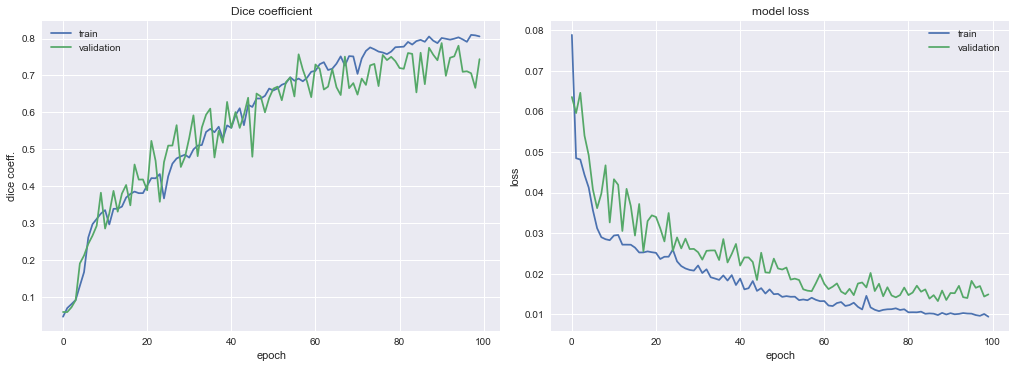

In [28]:
plt.style.use('seaborn')


fig, ax = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
ax[0].plot(history.history['dice_coe'])
ax[0].plot(history.history['val_dice_coe'])
ax[0].set_title('Dice coefficient')
ax[0].set_ylabel('dice coeff.')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'validation'], loc='best')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'validation'], loc='best')



plt.show()


fig.savefig('../data/plots/' + model_name )

### Predictions

In [29]:
validation_generator = create_segmentation_generator_validation(data_dir_validation_img, data_dir_validation_mask, 1, IMG_SIZE, SEED)

Found 45 images belonging to 1 classes.
Found 45 images belonging to 1 classes.


In [30]:
def show_prediction(datagen, num=1):
    for i in range(0, num):
        image, mask = next(datagen)
        pred_mask = model.predict(image) 
        display([image[0], mask[0], pred_mask[0]])

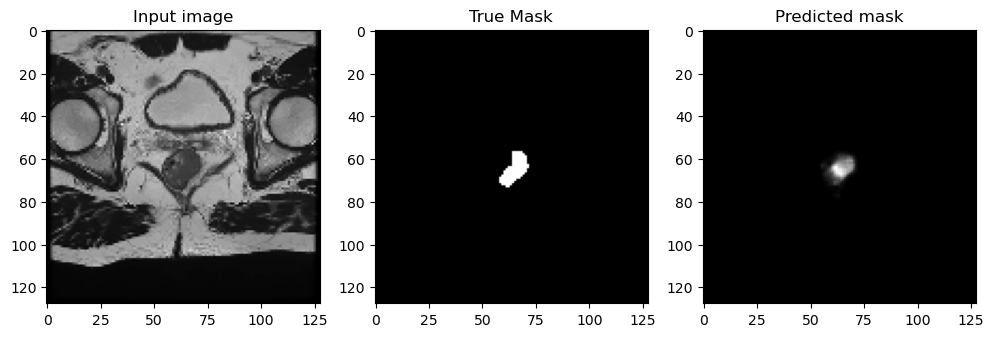

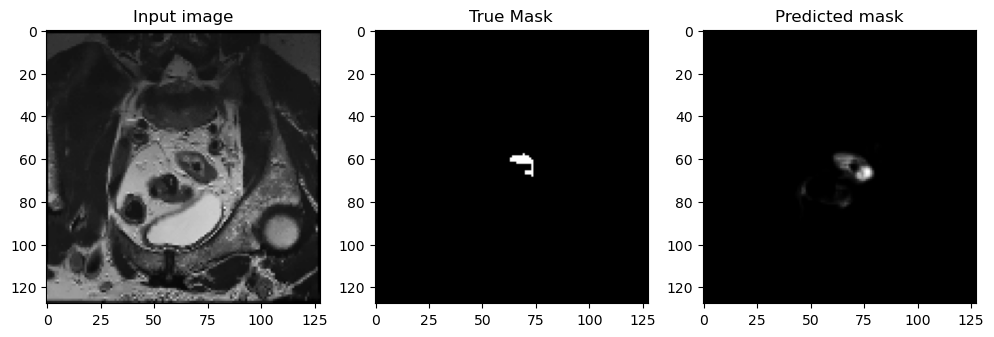

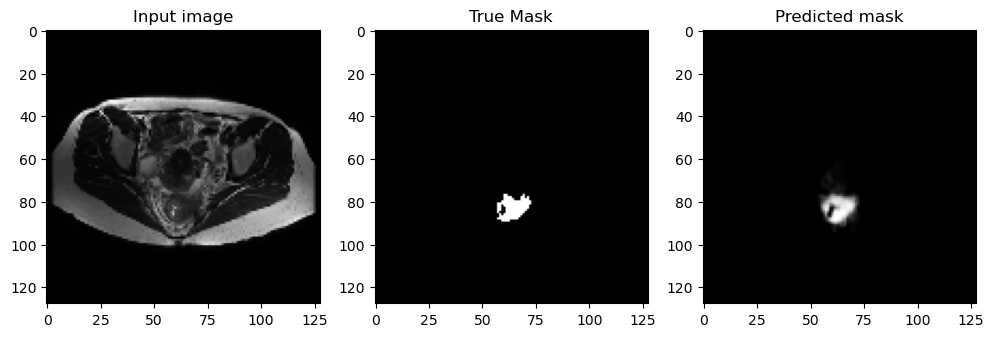

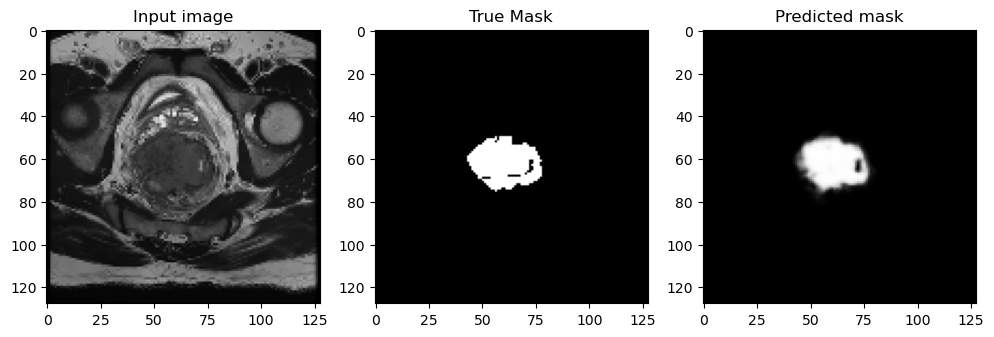

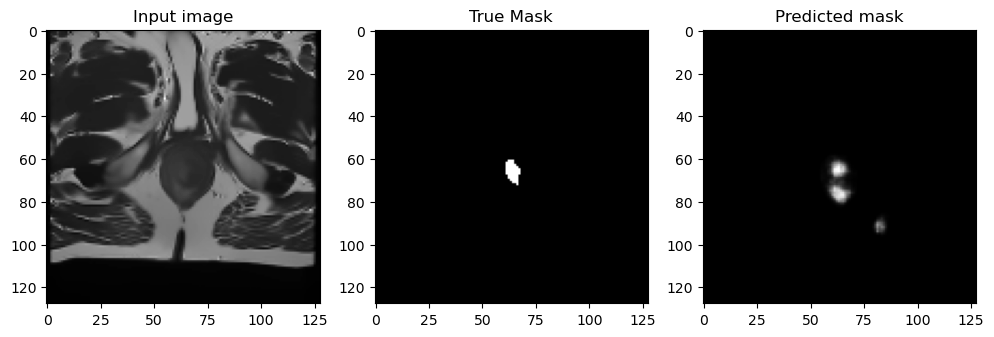

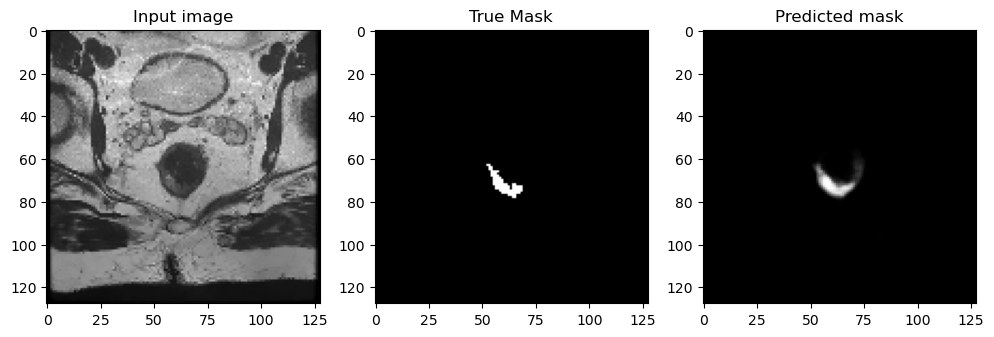

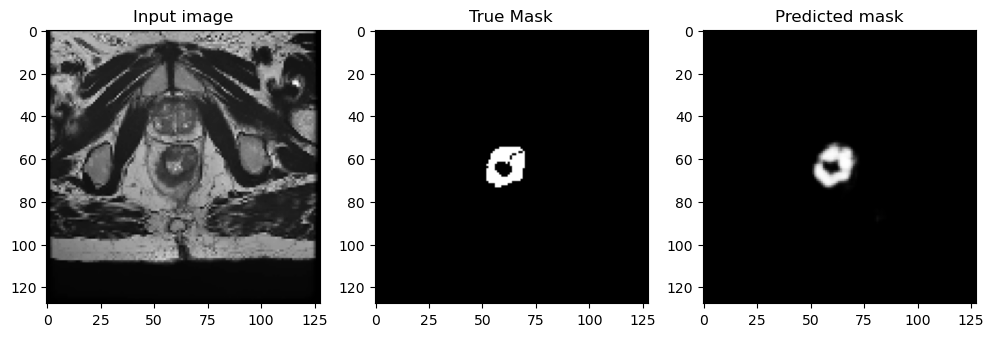

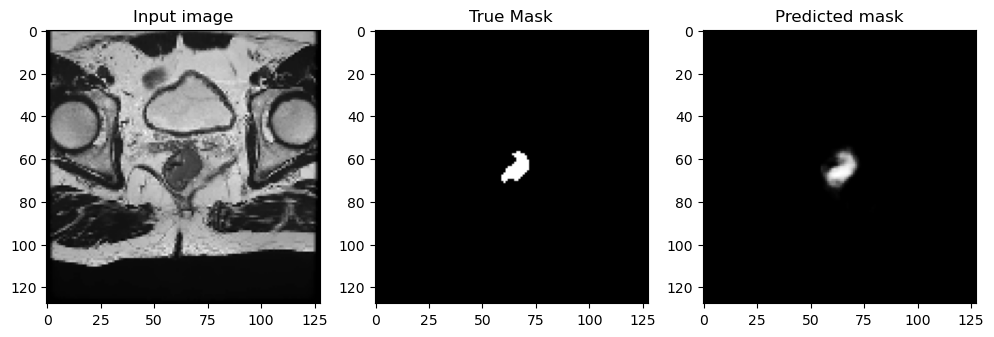

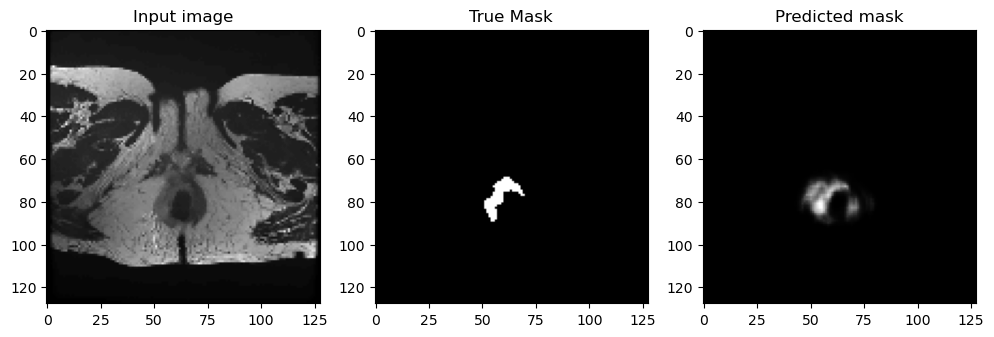

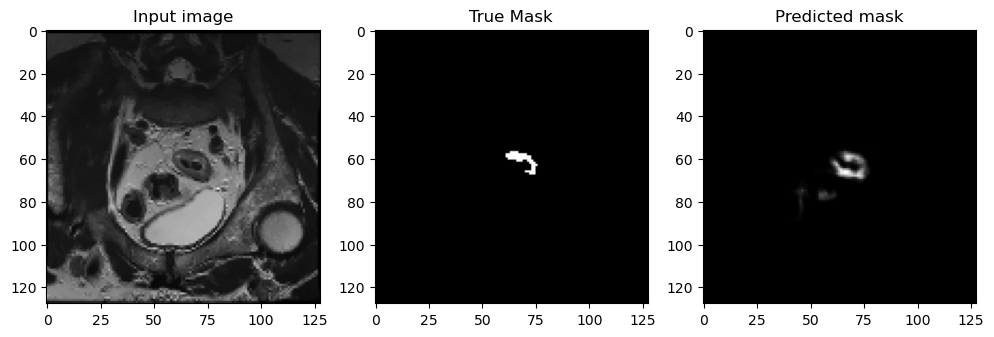

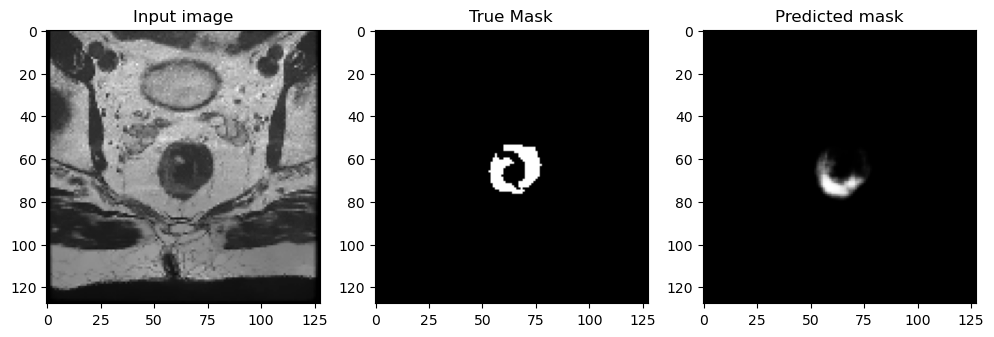

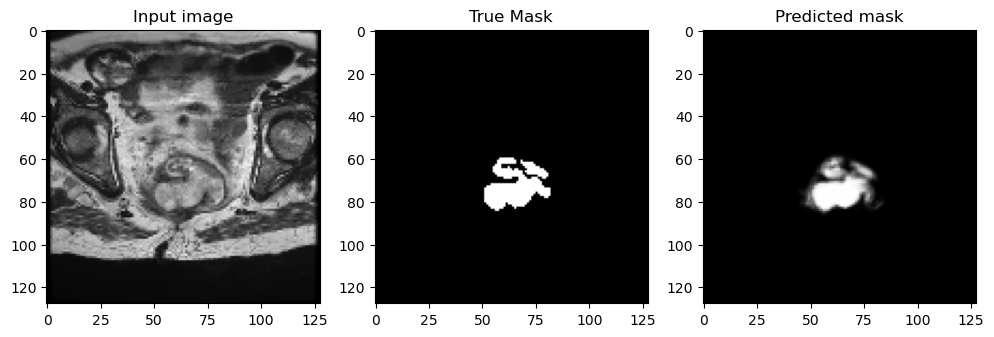

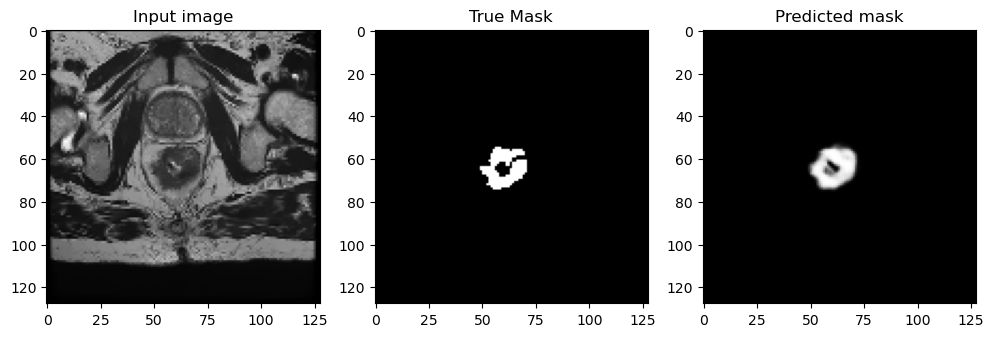

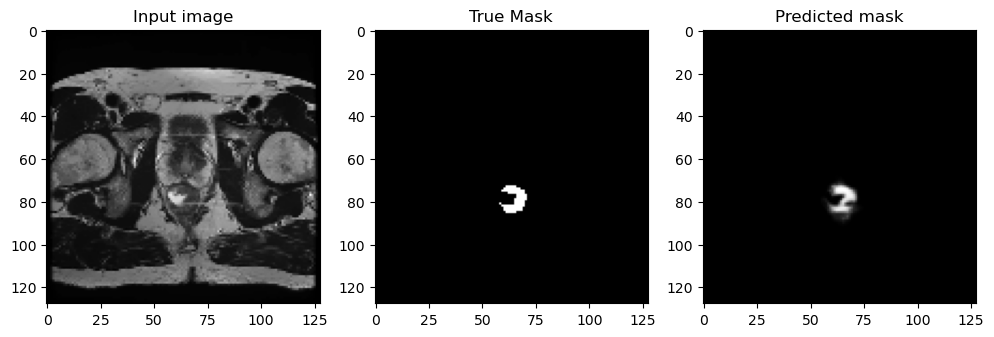

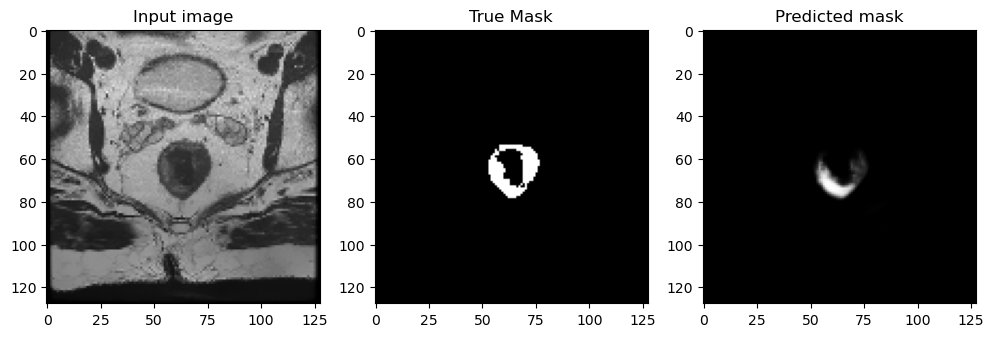

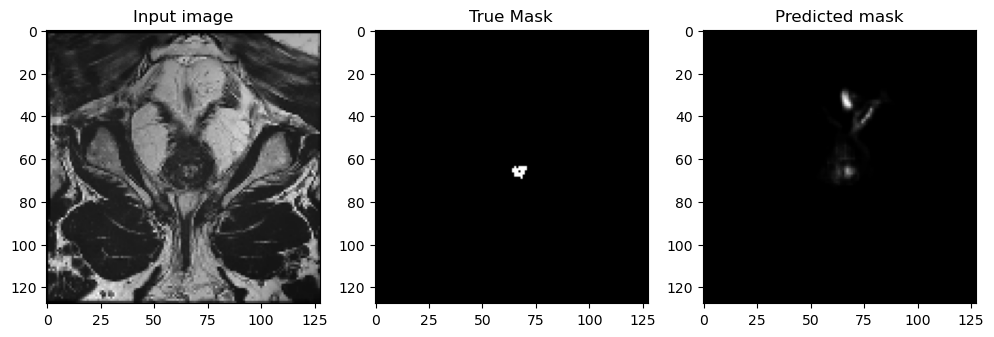

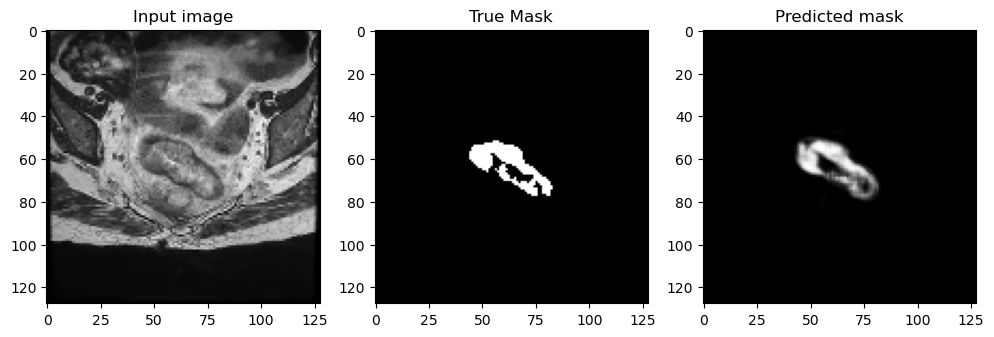

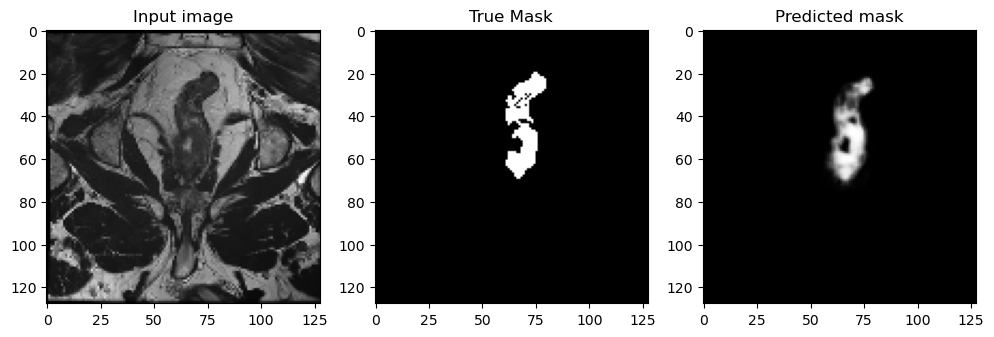

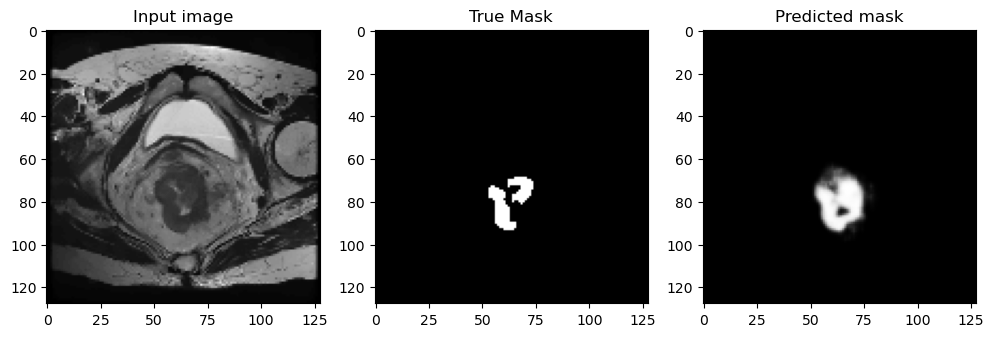

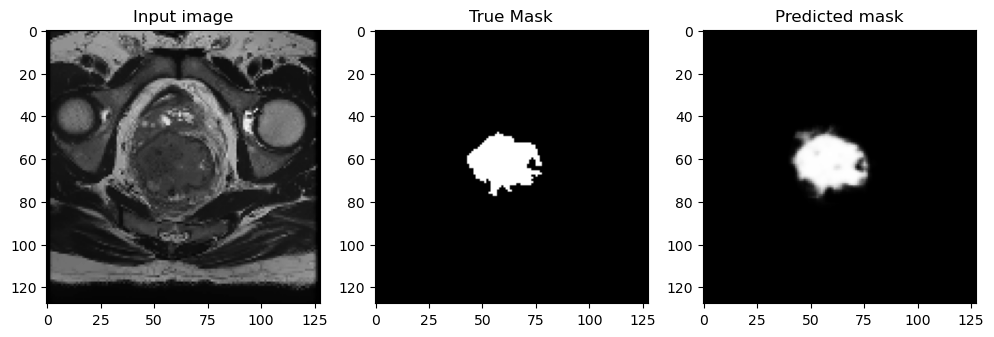

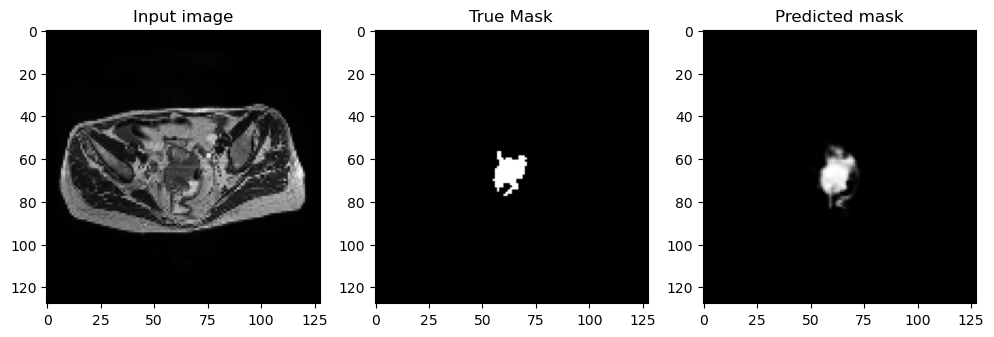

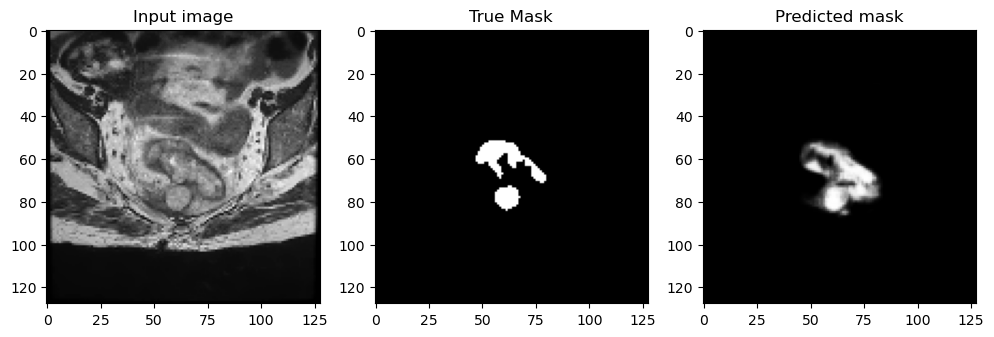

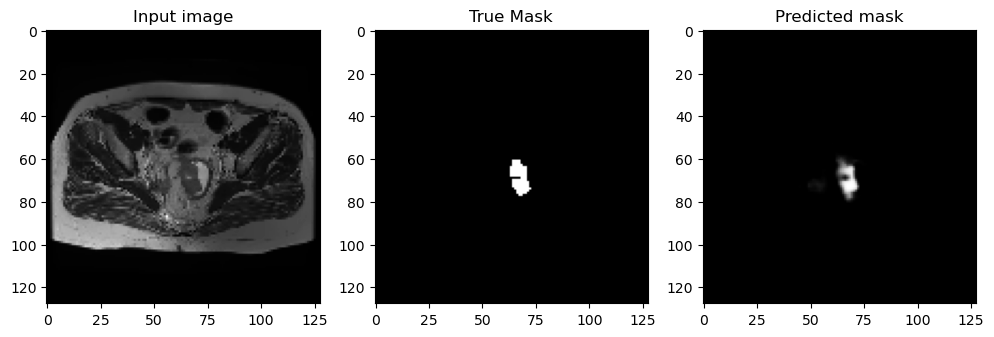

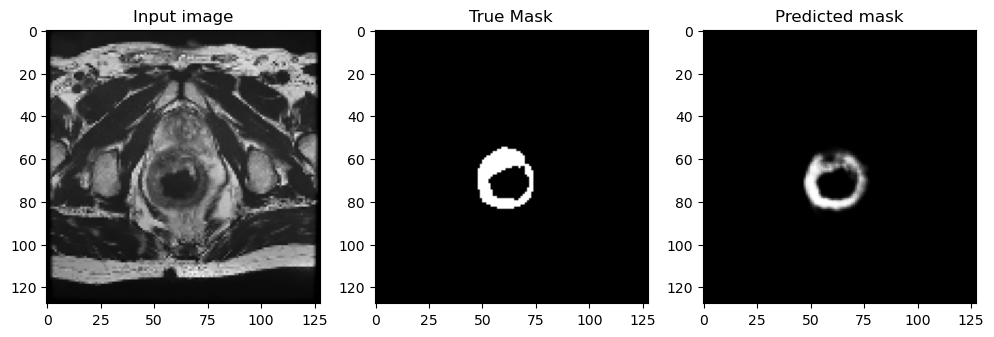

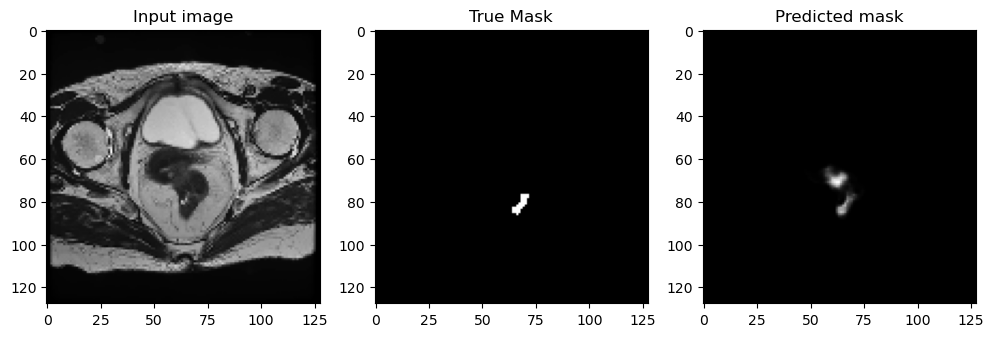

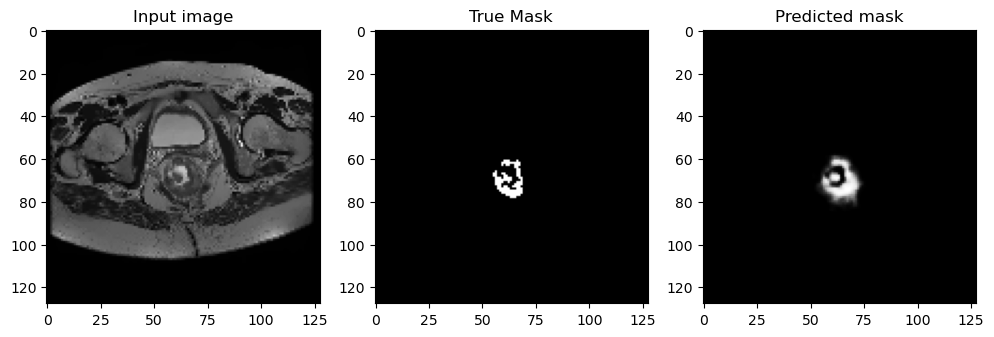

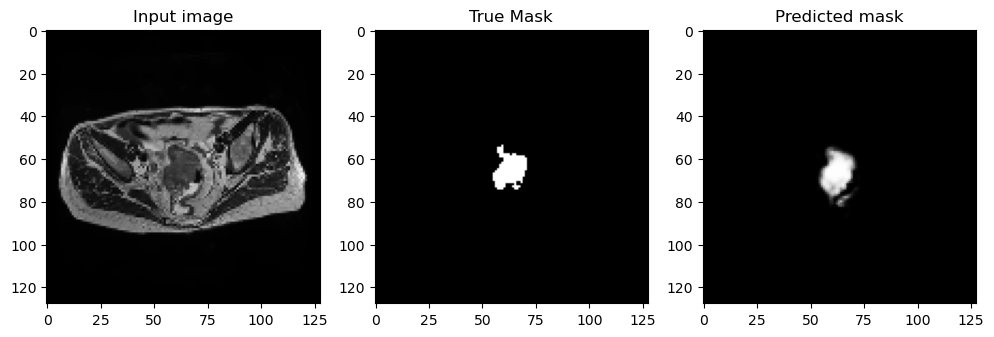

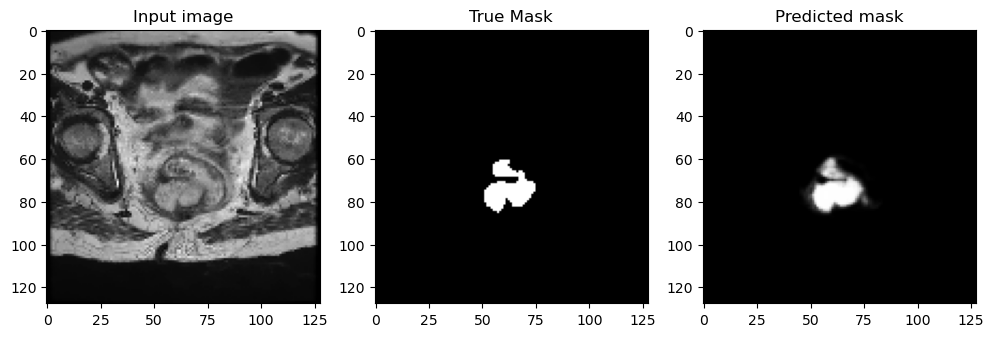

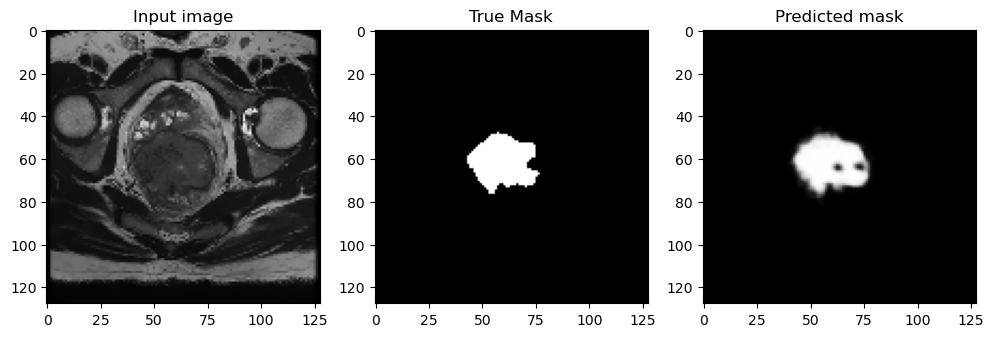

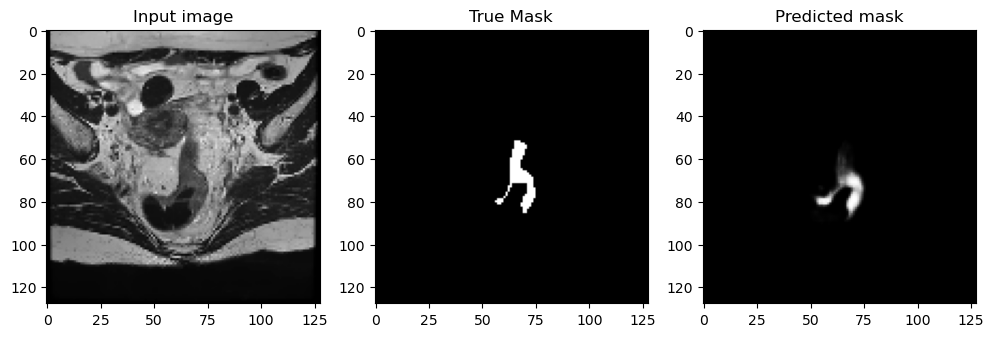

In [31]:
plt.style.use('default')

show_prediction(validation_generator, 30)

Found 17 images belonging to 1 classes.
Found 17 images belonging to 1 classes.


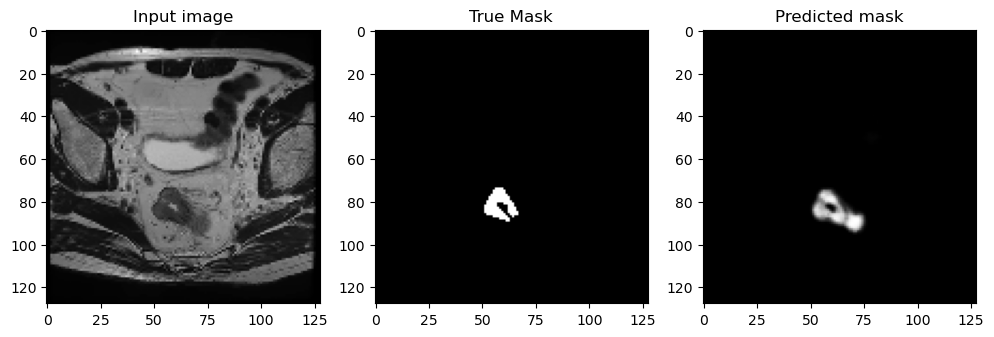

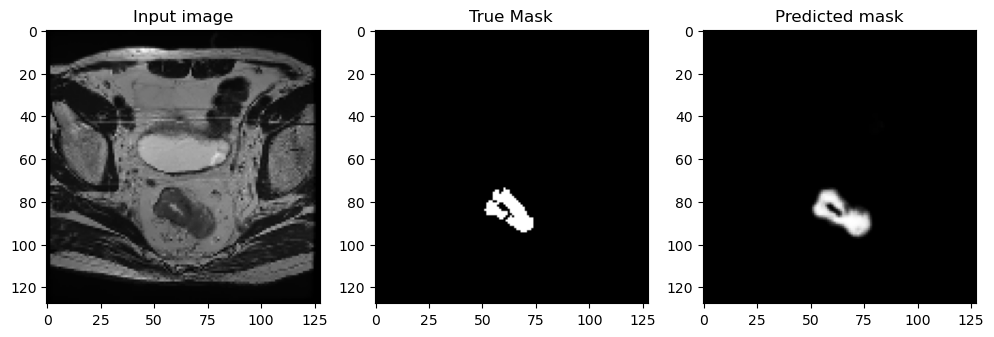

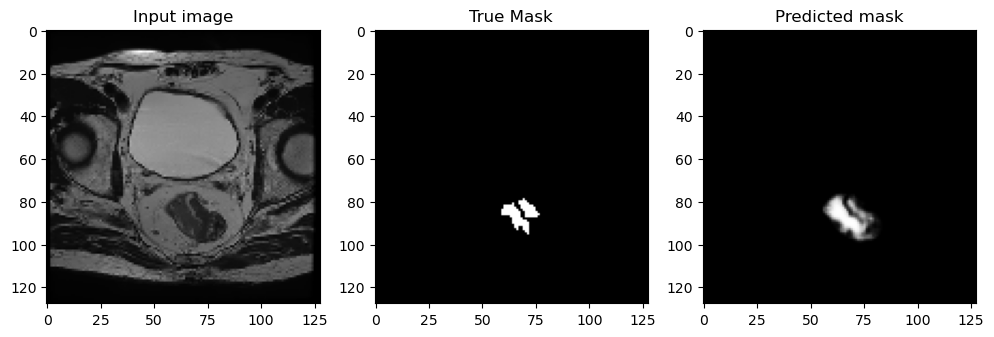

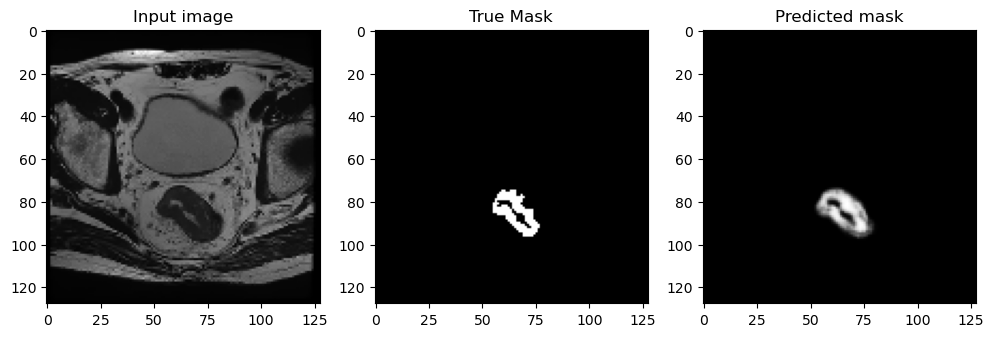

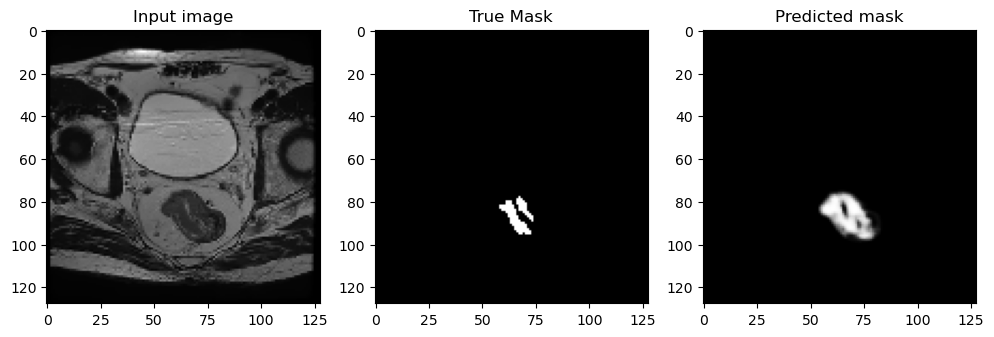

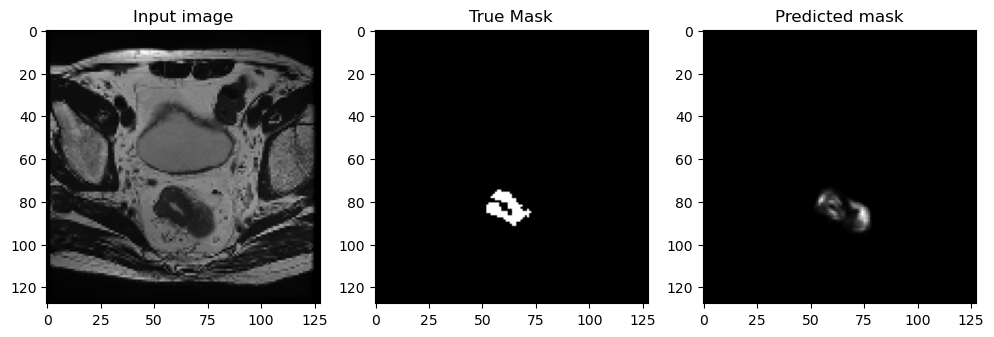

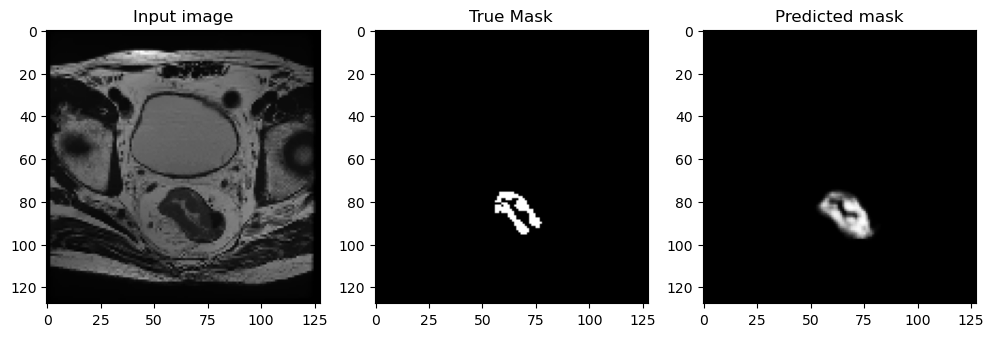

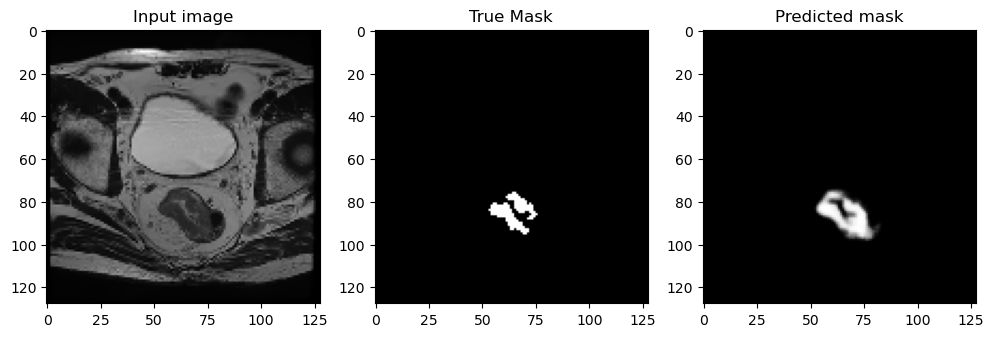

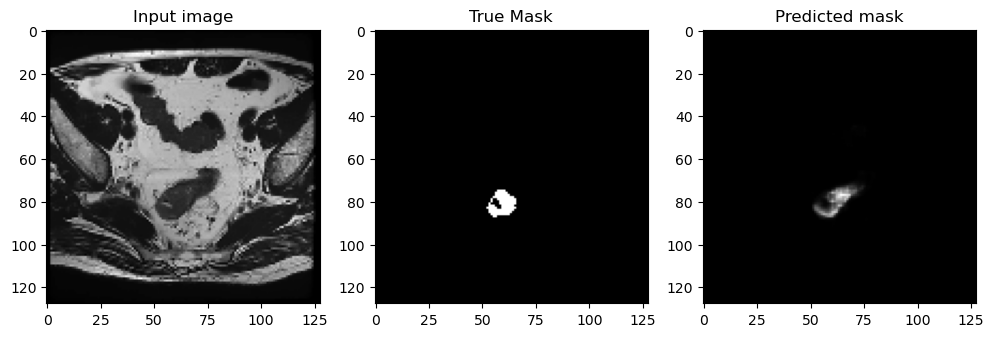

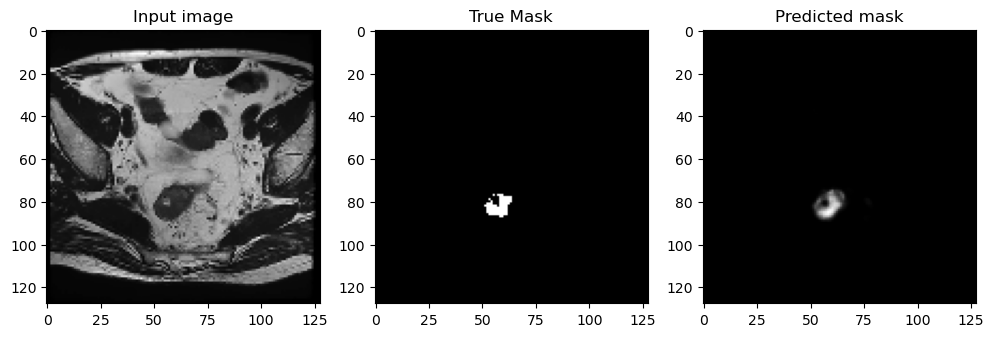

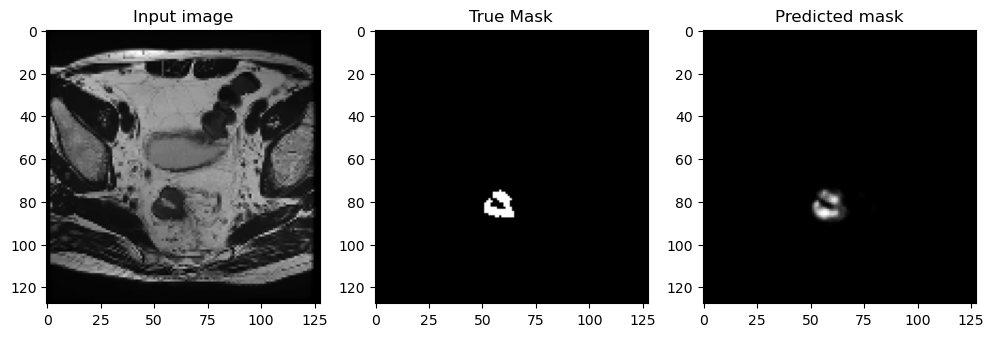

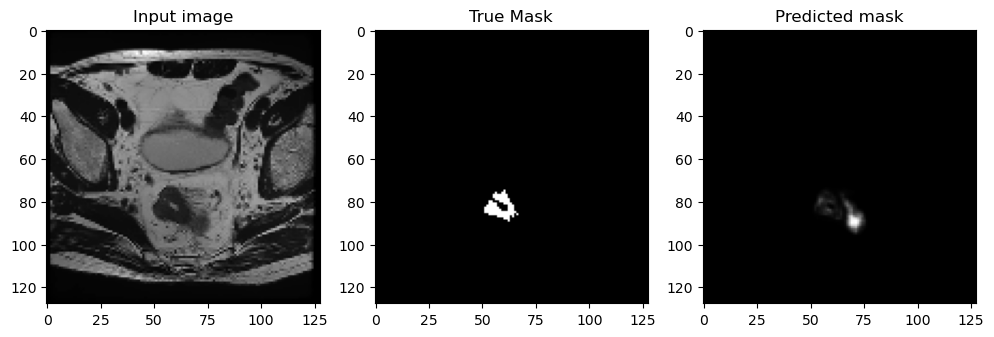

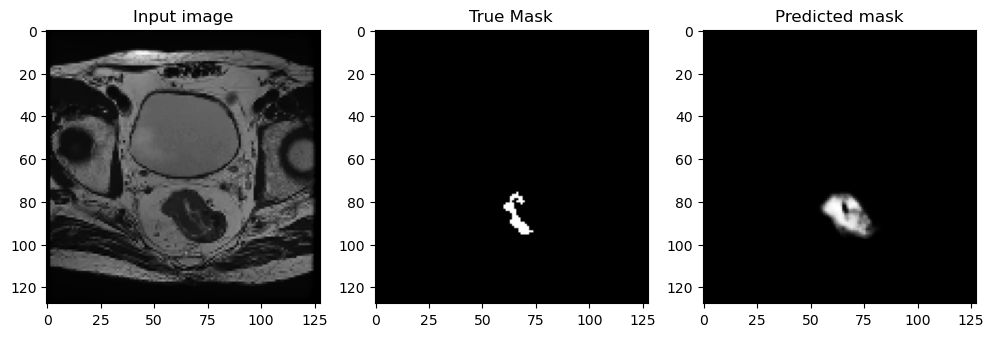

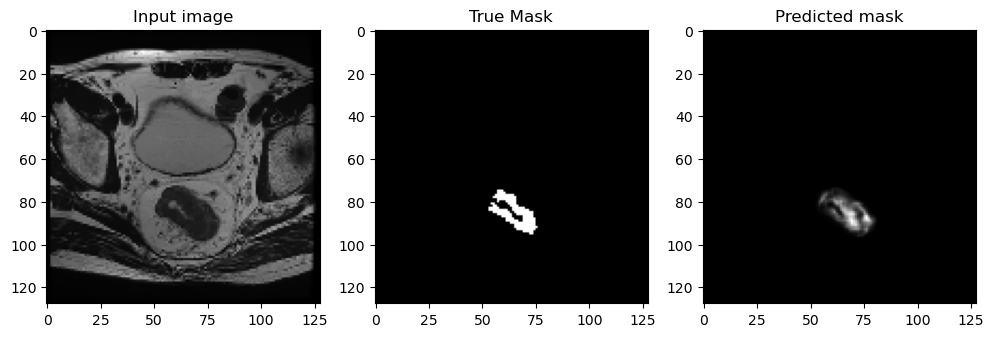

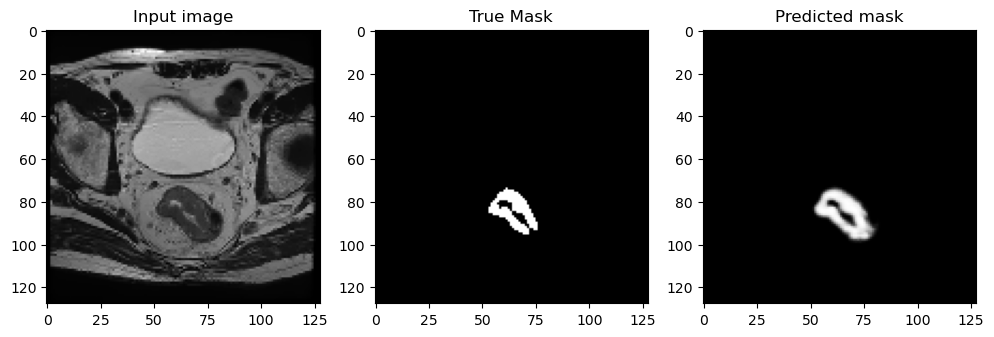

In [32]:

test_generator = create_segmentation_generator_validation(data_dir_test_img, data_dir_test_mask, 1, IMG_SIZE, SEED)

show_prediction(test_generator, 15)